<h1 id="tocheading">Finding Patterns in Data using IBM Power and PowerAI</h1>
<div id="toc"></div>

In this lab we will explore an open source data set, and discover how we can use the tools that are part of **PowerAI** to explore and discover patterns in the data.  For this lab, we will make use of the Lending Club data set, pandas, numpy and scikit learn libraries.  Here is a brief description about Lending Club.



<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-banner.png" width="800" height="500" align="middle"/>

[Lending Club (LC)](https://www.lendingclub.com/) is the world’s largest online marketplace connecting borrowers and investors. It is transforming the banking system to make credit more affordable and investing more rewarding. Lending Club operates at a lower cost than traditional bank lending programs and pass the savings on to borrowers in the form of lower rates and to investors in the form of solid risk-adjusted returns.

**The DATA**  
The original data set is downloaded from [LC](https://www.lendingclub.com/info/download-data.action) covering complete loan data for all loans issued through the 2007-2018, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. Additional features include credit history, number of finance inquiries, address including zip codes, and state, and collections among others. It is quite rich and is an excellent example of credit risk data.  Interestingly, Goldman Sachs’ new peer-to-peer lending platform called Marcus was built almost entirely using the Lending Club data.

Here is a link to some extra information regarding the fields of the data set.
[Data Dictionary](https://github.com/dustinvanstee/mldl-101/blob/master/lab5-powerai-lc/LCDataDictionary.csv)

**Important**

In this notebook, we will play with the lending club data, conduct a set of exploratory analysis and try to apply various machine learning techniques to predict borrower’s default. We took a small sample of loans made in 2016 (130K) to help speed up the processing time for the lab


Note : to remove a lot of the busy verbose code, we are making using of a utility python file called lc_utils.py.  For implemenation details you can refer here [python code](https://github.com/dustinvanstee/mldl-101/blob/master/lab5-powerai-lc/lc_utils.py)

### Quick word on the data science method
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/dsx-methodology.png" width="900" height="700" align="middle"/>

Here we will use these simple high level steps to work through a typical data science problem.  This workflow is meant to be a high level guide, but in practice this is a highly iterative approach ...

### Goals

* Perform some initial analysis of the data for **Business Understanding**
* **Prepare the Data** for our visualization and modeling
* **Visualize** the data
* Model using **Dimension Reduction** and **Classification** techniques
* **Evaluate** the approach

## Business/Data Understanding and Preparation
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-bu-dp.png" width="800" height="500" align="middle"/>

### Import Libraries

In [1]:
# Code functions that are needed to run this lab
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math

import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob

# custom library for some helper functions 
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import myenv as myenv
from lc_utils import *


In [2]:
%load_ext autoreload
%autoreload 2
from lc_utils import *

### Load the Data
Here we load data that was previously downloaded from lendingclub.com.  For speed of this lab, we are restricting the number of loans ~ 130K

In [3]:
loan_df = load_sample_data('UTSA')
loan_df_orig = loan_df.copy()
loan_df.head()

**load_sample_data** : Setting data location to /gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/
**load_sample_data** : Found 1 files.  CSV files = ['/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q1.csv.gz']
**load_sample_data** : Loading /gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q1.csv.gz


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,16098.340000,16098.34,16000.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,16630.580000,16630.58,15143.02,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939

### Descriptive Statistics (1D)
Lets look at some 1D and 2D descriptive statistics for this dataset

In this dataset, we have all types of data.  Numerical, Categorical, Ranked data.  This small module will take you through what is typical done to quickly understand the data



In [4]:
# This function provide the number of rows/cols
# Information on the types of data
# and a report of descriptive statistics

quick_overview_1d(loan_df)

**quick_overview_1d** : There are 133889 observations in the dataset.
**quick_overview_1d** : There are 151 variables in the dataset.
**quick_overview_1d** : 
Categorical vs Numerical
**quick_overview_1d** : use df.dtypes ...
float64    112
object      39
Name: type, dtype: int64
**quick_overview_1d** : 
******************Dataset Descriptive Statistics (numerical columns only) *****************************

 running df.describe() ....


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133870.000000,133887.000000,133887.000000,133887.000000,133886.000000,69322.000000,23671.000000,133887.000000,133887.000000,1.338870e+05,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,38074.000000,133887.0,2661.000000,2659.000000,133887.000000,133887.000000,1.338870e+05,133825.000000,133826.000000,133826.000000,133826.000000,130186.000000,133826.000000,116008.000000,133826.000000,133826.000000,133826.000000,133820.000000,1.338870e+05,133826.000000,133825.000000,133825.000000,133887.000000,133887.000000,132776.000000,132712.000000,133887.000000,133887.000000,130241.000000,133887.000000,133887.000000,133887.000000,133887.000000,132843.000000,33756.000000,120089.000000,47783.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.00000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,126266.000000,133887.000000,133887.000000,133887.000000,133887.000000,132758.000000,133887.000000,133887.000000,1.338870e+05,1.338870e+05,1.338870e+05,1.338870e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,774.0,774.000000,774.0,774.000000,635.000000,774.000000,774.000000,1087.000000,1087.000000,1087.000000
mean,NaN,15589.394041,15589.394041,15581.984023,460.863923,8.046397e+04,19.547033,0.343476,695.750633,699.750827,0.576498,33.807810,66.361413,12.119922,0.238709,1.861627e+04,25.343245,5695.480540,5692.970475,10951.511813,10946.224173,8583.266797,2292.920647,1.102888e+00,74.221479,13.246068,3186.572260,687.161039,676.487710,0.021257,45.218154,1.0,108617.690135,18.603103,0.006969,259.246596,1.472398e+05,1.045373,2.797147,0.747157,1.625215,21.641175,35704.147819,70.741044,1.373769,2.930006,6183.582271,60.654499,3.636171e+04,0.952924,1.544121,2.187215,4.799159,13509.653738,10857.383932,59.762205,0.010120,21.343491,127.552652,188.682553,13.155243,7.799757,1.671402,23.845607,38.836799,6.812589,35.217672,0.518908,3.809533,5.917796,4.955836,8.00

Here we can get a quick assessment of the statistics for each column.  
**Quick Question** can you answer what was the average income for the 133K loan applicants ?

### Descriptive Statistics (2D)
Since we have over 100 numerical variables, creating a 2D correlation plot may be time consuming and difficult to interpret.  Lets look at correlations on a smaller scale for now....


**quick_overview_2d** : There are 133889 observations in the dataset.
**quick_overview_2d** : There are 151 variables in the dataset.


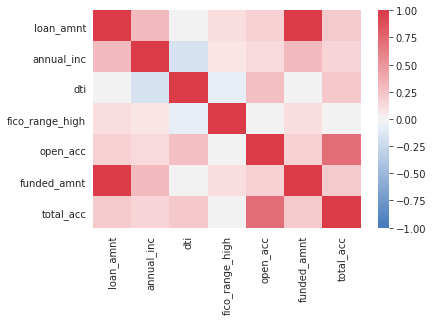

In [5]:
# Grab only a subset of columns
cols = ["loan_amnt","annual_inc","dti","fico_range_high","open_acc",'funded_amnt', 'total_acc']
quick_overview_2d(loan_df, cols)

**Quick Question** : Can you find a negatively correlated variable to annual_inc in the chart above?  Can you think of a reason for this result ?

### Create Loan Default column.  This is the column we will predict later
The **loan_status** column contains the information of whether or not the loan is in default. 

This column has more than just a 'default or paid' status.  Since our goal is to build a simple default classifier , we need to make a new column based off the **loan_status** column.

Here we will look at all the categorical values in **loan_status**, and create a new column called **default** based off that one.


In [6]:
# function to create loan status .... 
loan_df = create_loan_default(loan_df)
loan_df.head(3) # scroll to the right, and see the new 'default' column

**create_loan_default** : Unique values in loan_status
Current               79931
Fully Paid            35650
Charged Off           13043
Late (31-120 days)     3157
In Grace Period        1637
Late (16-30 days)       458
Default                  11
Name: loan_status, dtype: int64
13479
20714
29087
**create_loan_default** : Unique values in loan_status
Current               96134
Charged Off           29087
Fully Paid             7434
Late (31-120 days)      774
In Grace Period         350
Late (16-30 days)       105
Default                   3
Name: loan_status, dtype: int64
**create_loan_default** : Dropping other values that are highly correlated with loan_status
**create_loan_default** : Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv
**create_loan_default** : Unique values in default
0    103920
1     29969
Name: default, dtype: int64


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,default
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939.0,16300.0,27831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Data Preparation - Handle Null Values aka NaNs ...

One part of the data science process thats especially time consuming is working with unclean data.  This lending club data set is a great example of that.  If you look at the dataframe shown above, you will see a number of columns with the indicator **NaN** .  This means 'not a number' and needs to be dealt with prior to any machine learning steps.  You have many options here.  Some options are listed below...

* Fill with a value -> impute mean/median/min/max/other
* drop rows with NaNs
* drop columns with large number of NaNs 
* use data in other columns to derive

All these methods are possible, but its up to the data scientist / domain expert to figure out the best approach.  There is definitely some grey area involved in whats the best approach.

First, lets understand which columns have NaNs...

In [7]:
# For every column, count the number of NaNs .... 
# code hint : uses df.isna().sum()

columns_with_nans(loan_df)

**columns_with_nans** : id                                                 0
member_id                                     133889
loan_amnt                                          2
funded_amnt                                        2
funded_amnt_inv                                    2
term                                               2
int_rate                                           2
installment                                        2
grade                                              2
sub_grade                                          2
emp_title                                       8983
emp_length                                      8946
home_ownership                                     2
annual_inc                                         2
verification_status                                2
issue_d                                            2
pymnt_plan                                         2
url                                                2
desc                  


As you can see, we have some work to do to clean up the NaN values.  Beyond NaN values, we also have to transform columns if they aren't formatted correctly, or maybe we want to transform a column based on custom requirements.  

```
Example : column=employee_length , values=[1,2,3,4,5,6,7,8,9,10+] formatted as a string
          transform into 
          column=employee_length, [0_3yrs,4_6yrs,gt_6yrs] (categorical:strings)
```
          
Luckily, we took care to process and clean this data below using a few functions.  In practice, **this is where data scientists spend a large portion of their time** as this requires detailed domain knowledge to clean the data.  We have made a fair number of assumptions about how to process the data which we won't go into due to time contraints for the lab.

In [8]:
# The following cleaning of the data makes use of the steps shown below.....

#loan_df1 = drop_sparse_numeric_columns(loan_df)
#loan_df2 = drop_columns(loan_df1)
#loan_df3 = impute_columns(loan_df2)
#loan_df4 = handle_employee_length(loan_df3)
#loan_df5 = handle_revol_util(loan_df4)
#loan_df6 = drop_rows(loan_df5)

loan_df = clean_lendingclub_data(loan_df)


**clean_lendingclub_data** :  Running a couple routines to clean the data ...
**drop_sparse_numeric_columns** : Dropping columns with less than 0.025 pct cells populated
**transform** : Dropping member_id since its 0.0 pct populated
**transform** : Dropping annual_inc_joint since its 0.01987467230317651 pct populated
**transform** : Dropping dti_joint since its 0.019859734556236883 pct populated
**transform** : Dropping revol_bal_joint since its 0.0 pct populated
**transform** : Dropping sec_app_fico_range_low since its 0.0 pct populated
**transform** : Dropping sec_app_fico_range_high since its 0.0 pct populated
**transform** : Dropping sec_app_earliest_cr_line since its 0.0 pct populated
**transform** : Dropping sec_app_inq_last_6mths since its 0.0 pct populated
**transform** : Dropping sec_app_mort_acc since its 0.0 pct populated
**transform** : Dropping sec_app_open_acc since its 0.0 pct populated
**transform** : Dropping sec_app_revol_util since its 0.0 pct populated
**transform**

In [9]:
# Final Sanity check ....
# If we did our job right, there should not be any NaN's left.  
# Use this convenience function to check

# code hint df.isna().sum()

columns_with_nans(loan_df)

**columns_with_nans** : id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_rec_int   

### Data Preparation - Handle Time Objects
Sometimes for columns that contain date information, you may want to break them down into individual columns like month, day, day of week etc.  For our use case, we will create a new column called `time_history` that will indicate how long an applicant has been a borrower.  This is an example of **feature engineering**.  Essentially, using business logic to create a new column (feature) that may have predictive value.

In [10]:
loan_df = create_time_features(loan_df)
loan_df.head(3)

**create_time_features** : Creating new column called time_history : Calculated feature showing how long applicant has been a borrower..


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,default,emp_bin,revol_util_1,time_history
0,76003542,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,RENT,105000.0,Not Verified,2016-03-01,n,debt_consolidation,206xx,MD,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.0,0.0,6219.0,21.0,w,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,Individual,0.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,0.0,95.2,0.0,0.0,0.0,23525.0,19400.0,Cash,N,0,gt_6yrs,0.279896,5599
1,76023477,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,MORTGAGE,40000.0,Verified,2016-03-01,n,credit_card,440xx,NC,24.30,0.0,2006-08-01,705.0,709.0,0.0,4.0,0.0,14009.0,8.0,w,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,Individual,0.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,0.0,100.0,100.0,0.0,0.0,31939.0,16300.0,Cash,N,0,gt_6yrs,0.451772,3500
2,75993535,15000.0,15000.0,15000.0,60 months,15.31%,359.30,C,C5,MORTGAGE,70000.0,Source Verified,2016-03-01,n,home_improvement,750xx,TX,9.99,0.0,2002-01-01,690.0,694.0,0.0,6.0,0.0,11630.0,22.0,w,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,Individual,0.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,3.0,95.5,33.3,0.0,0.0,27322.0,16000.0,Cash,N,0,gt_6yrs,0.436725,5173


### Convert Categorical Data to One hot encode ###

If you look above at the data frame, we are almost ready to start building models.  However, there is one important step to complete.  Notice we have some columns that are still built out of string data 
```
example column=home_ownership values=[RENT, MORTGAGE, OWN]
```
Machine learning algorithms only process numerical data, so we need to transform these **categorical columns** into **indicator columns**

From the example above, the transform would yield 3 new columns

```
example column=RENT values=[0,1]
        column=MORTGAGE values=[0,1]
        column=OWN values=[0,1]
```

Conveniently pandas has a nice function called **get_dummies** that we will use for this purpose

In [11]:
# Transform categorical data into binary indicator columns
# code hint, uses pd.get_dummies

loan_df = one_hot_encode_keep_cols(loan_df)
loan_df.head() # once complete, see how many new columns you have!

**one_hot_encode_keep_cols** : Dropping these columns since they are greater than cardinality limit of 50
**one_hot_encode_keep_cols** : ['id', 'int_rate', 'zip_code', 'addr_state']
**one_hot_encode_keep_cols** : Keeping these cols
**one_hot_encode_keep_cols** : ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type', 'disbursement_method', 'debt_settlement_flag', 'emp_bin']


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,default,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,f,w,Individual,Joint App,Cash,DirectPay,N,Y,0_3yrs,4_6yrs,gt_6yrs,id
0,16000.0,16000.0,16000.0,481.84,105000.0,2016-03-01,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.0,0.0,6219.0,21.0,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,0.0,95.2,0.0,0.0,0.0,23525.0,19400.0,0,0.279896,5599,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,2016-03-01,24.30,0.0,2006-08-01,705.0,709.0,0.0,4.0,0.0,14009.0,8.0,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,0.0,100.0,100.0,0.0,0.0,31939.0,16300.0,0,0.451772,3500,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,2016-03-01,9.99,0.0,2002-01-01,690.0,694.0,0.0,6.0,0.0,11630.0,22.0,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,3.0,95.5,33.3,0.0,0.0,27322.0,16000.0,0,0.436725,5173,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,75993535
3,2425.0,2425.0,2425.0,84.44,25000.0,2016-03-01,38.50,0.0,2007-09-01,705.0,709.0,0.0,7.0,0.0,10604.0,15.0,0.00,0.00,228.18,0.00,0.0,0.0,2062.67,714.0,710.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,24.0,15963.0,65.0,0.0,0.0,7288.0,72.0,0.0,0.0,0.0,1.0,13860.0,12.0,99.8,0.0,0.0,2.0,100.0,100.0,0.0,0.0,26567.0,7300.0,1,0.813877,3104,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,73458582
4,29900.0,29900.0,29900.0,1007.31,68000.0,2016-03-01,17.49,0.0,1991-11-01,675.0,679.0,2.0,14.0,1.0,13984.0,39.0,17215.02,17215.02,4396.13,0.00,0.0,0.0,1007.31,604.0,600.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,3.0,10861.0,72.0,3.0,4.0,2917.0,66.0,0.0,0.0,5.0,6.0,40787.0,703.0,91.1,0.0,0.0,2.0,100.0,100.0,1.0,0.0,24845.0,7900.0,1,0.318658,8887,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,73511090


### Final Result after data preparation ....

Ok, so you made it here, lets take a look at the final results of your data preparation work.  It may be helpful to  **qualitatively compare** your original data frame to this one and see how different they look..  Execute the cells below to get a sense of what the tranformations accomplished.

In [12]:
loan_df_orig.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,16098.340000,16098.34,16000.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,16630.580000,16630.58,15143.02,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939

In [13]:
loan_df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,default,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,f,w,Individual,Joint App,Cash,DirectPay,N,Y,0_3yrs,4_6yrs,gt_6yrs,id
0,16000.0,16000.0,16000.0,481.84,105000.0,2016-03-01,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.0,0.0,6219.0,21.0,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,0.0,95.2,0.0,0.0,0.0,23525.0,19400.0,0,0.279896,5599,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,2016-03-01,24.30,0.0,2006-08-01,705.0,709.0,0.0,4.0,0.0,14009.0,8.0,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,0.0,100.0,100.0,0.0,0.0,31939.0,16300.0,0,0.451772,3500,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,2016-03-01,9.99,0.0,2002-01-01,690.0,694.0,0.0,6.0,0.0,11630.0,22.0,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,3.0,95.5,33.3,0.0,0.0,27322.0,16000.0,0,0.436725,5173,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,75993535


### Data Visualization
As you saw, when you 'describe' a data frame, you get a table statistics showing you the mean,min,max and other statistics about each column.  This is good, but sometimes its also good to look at the histograms of the data as well.  Lets Visualize some of the distributions from our dataset


<img src="https://github.com/dustinvanstee/random-public-files/raw/master/data-visualization.png" width="800" height="500" align="middle"/>

skipping column issue_d of type  datetime64[ns]
skipping column earliest_cr_line of type  datetime64[ns]
skipping column  36 months of type  uint8
skipping column  60 months of type  uint8
skipping column A of type  uint8
skipping column B of type  uint8
skipping column C of type  uint8
skipping column D of type  uint8
skipping column E of type  uint8
skipping column F of type  uint8
skipping column G of type  uint8
skipping column A1 of type  uint8
skipping column A2 of type  uint8
skipping column A3 of type  uint8
skipping column A4 of type  uint8
skipping column A5 of type  uint8
skipping column B1 of type  uint8
skipping column B2 of type  uint8
skipping column B3 of type  uint8
skipping column B4 of type  uint8
skipping column B5 of type  uint8
skipping column C1 of type  uint8
skipping column C2 of type  uint8
skipping column C3 of type  uint8
skipping column C4 of type  uint8
skipping column C5 of type  uint8
skipping column D1 of type  uint8
skipping column D2 of type  uint8
sk

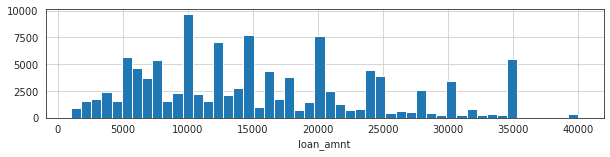

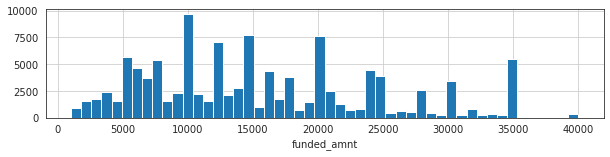

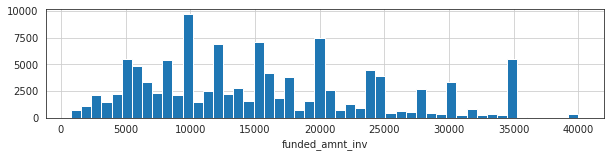

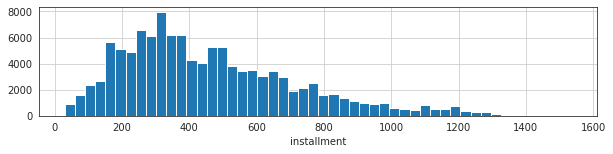

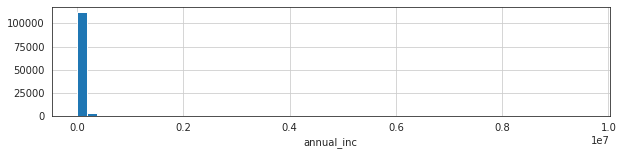

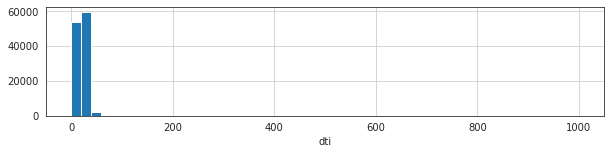

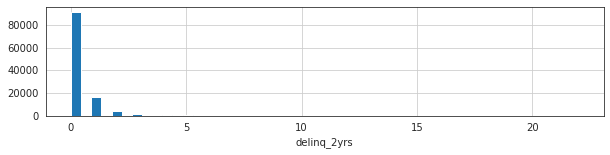

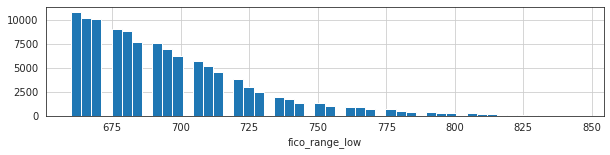

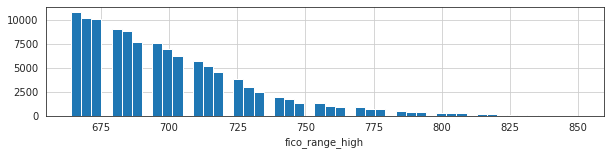

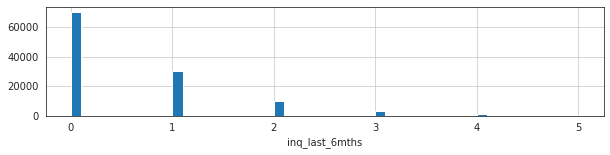

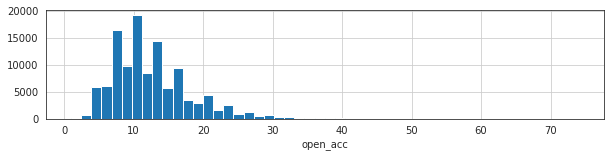

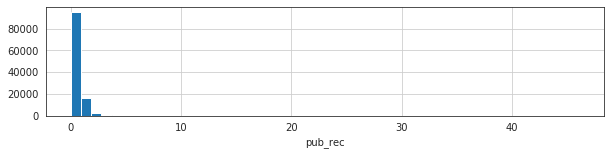

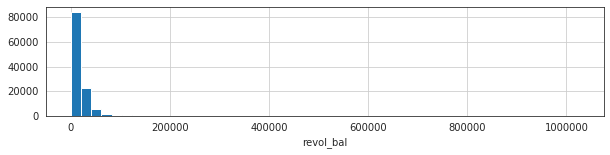

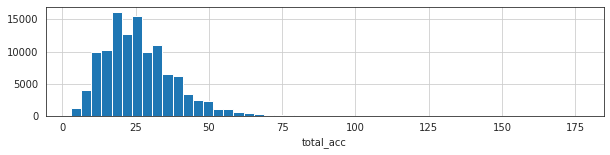

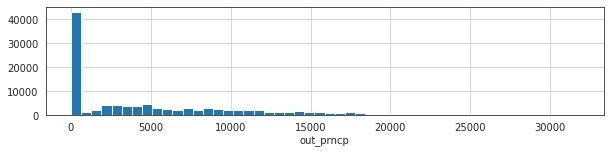

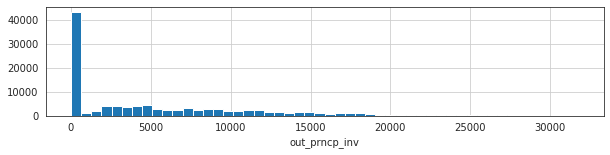

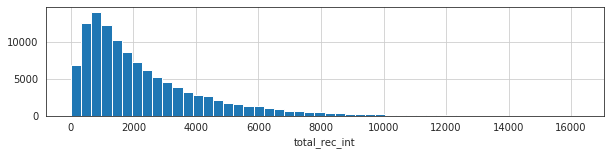

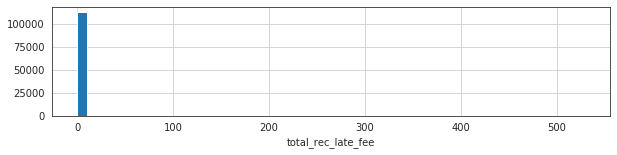

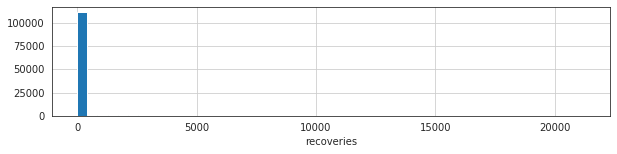

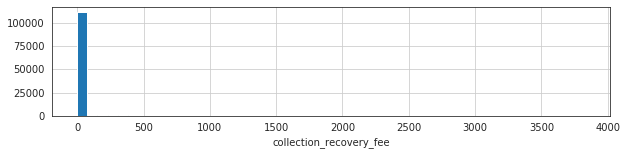

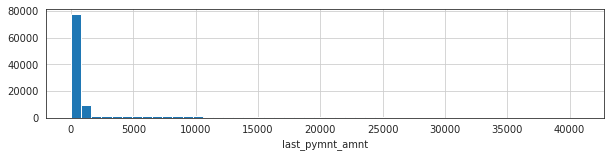

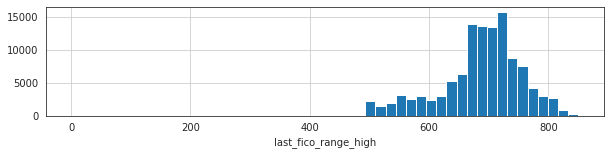

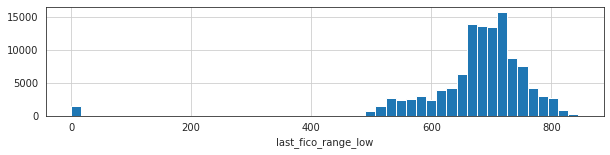

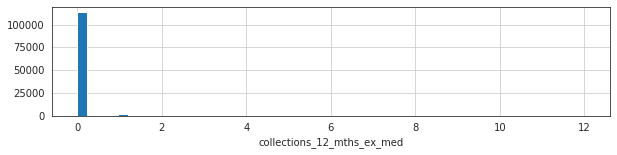

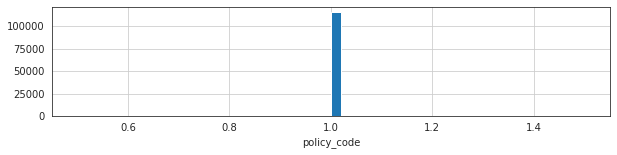

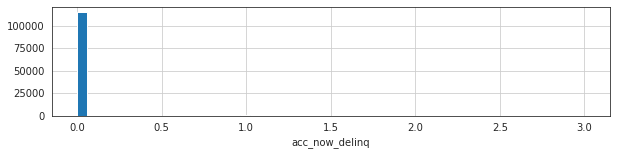

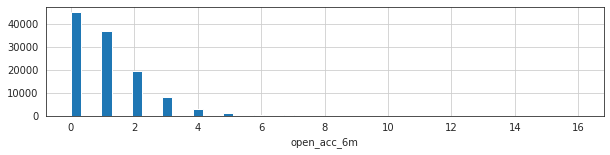

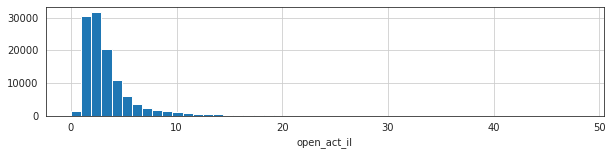

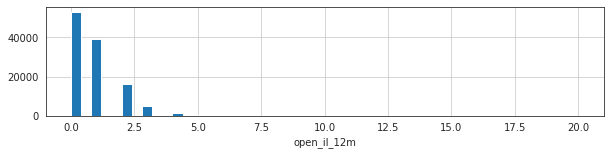

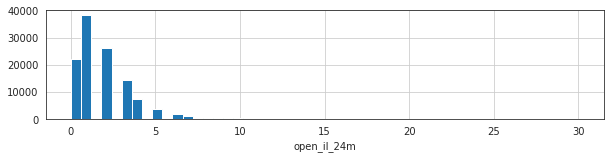

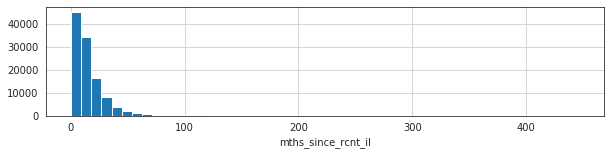

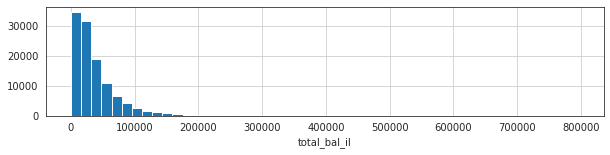

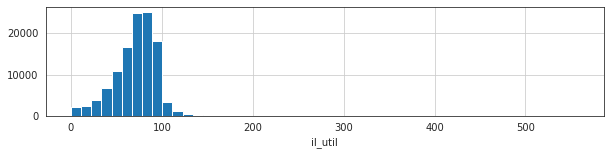

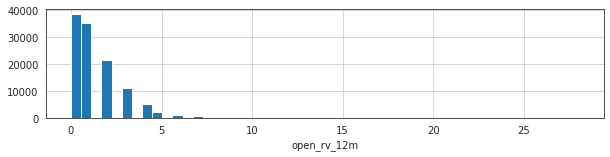

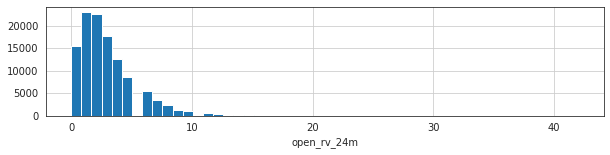

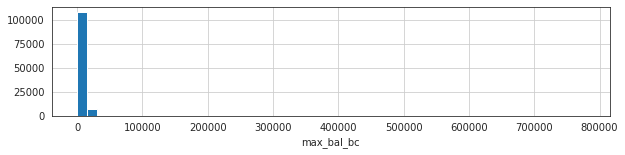

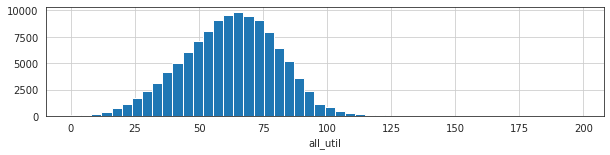

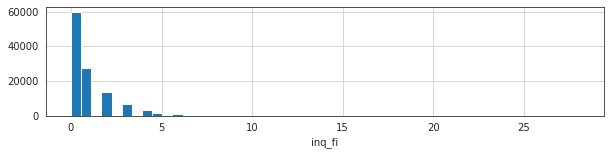

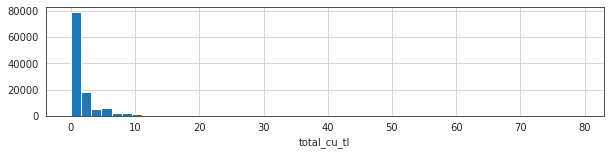

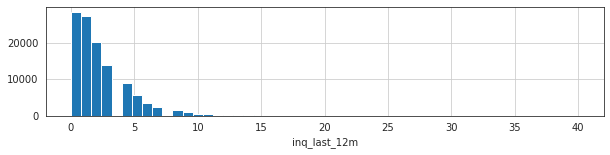

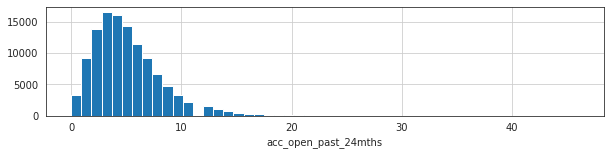

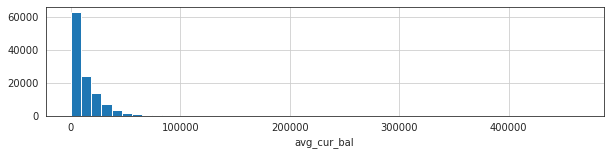

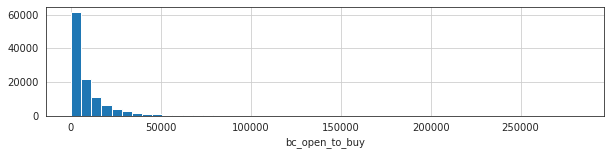

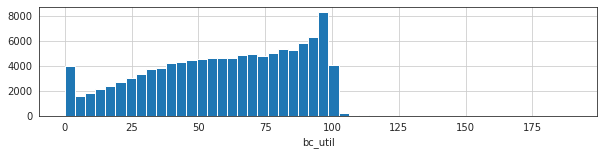

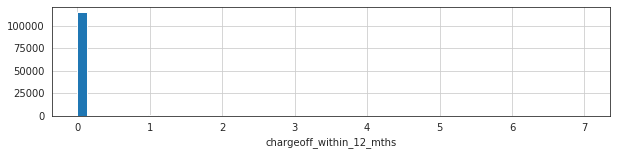

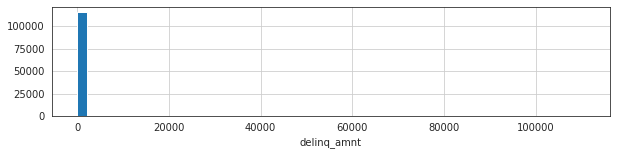

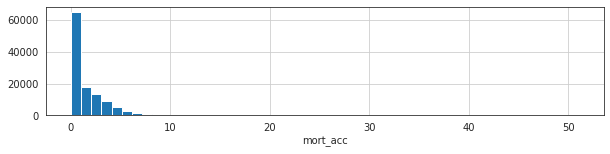

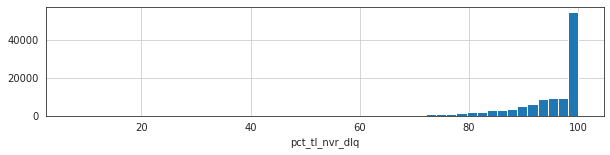

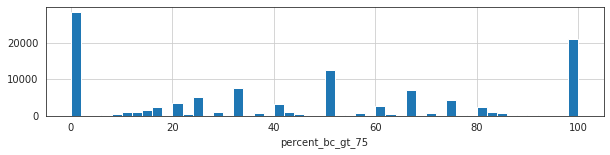

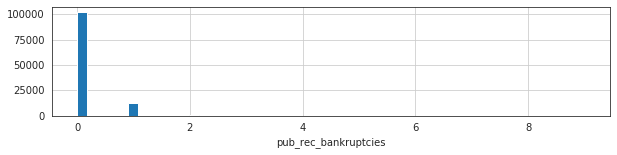

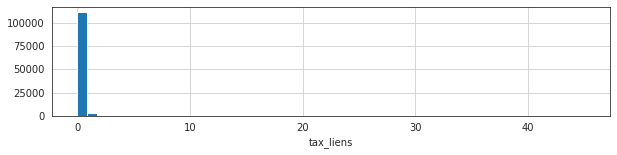

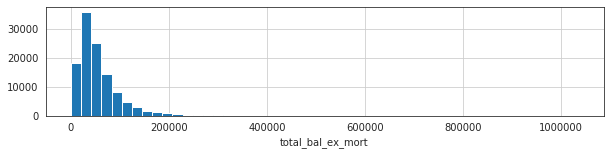

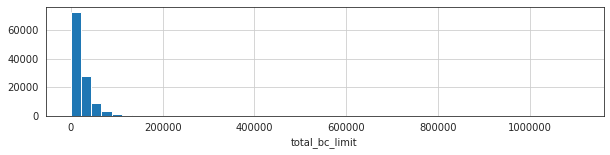

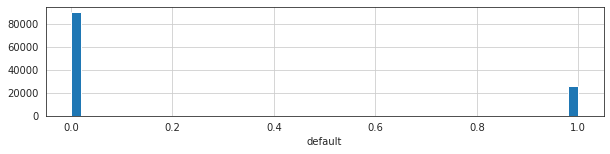

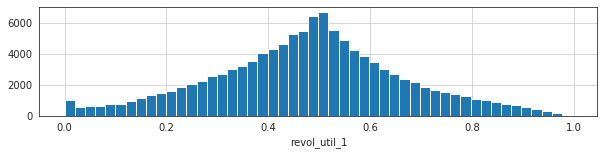

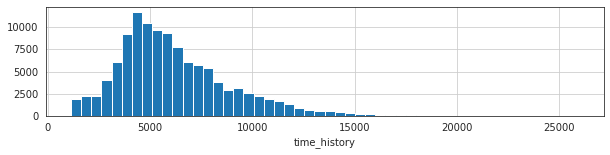

In [14]:
# Here we plot distribution charts for all the numerical columns in our dataframe
plot_histograms(loan_df)

## Data Visualization Examples
### The Growth of Lending Club

In [15]:
# Build a statistics data frame based on issue date
# aggregate on loan amount
vis_df = loan_df_orig.copy().sample(5000)

### Outcome Variable: Loan Status
On the left is the breakdown of all loan status classifications.  On the right is our simple default classification based on our data prep

In [16]:
df=vis_df[['loan_status', 'loan_amnt', 'funded_amnt']].groupby(['loan_status']).agg(['sum', 'count'])
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df=df.reset_index()
df

,loan_status,loan_amnt_sum,loan_amnt_count,funded_amnt_sum,funded_amnt_count
0,Charged Off,7479725.0,471,7479725.0,471
1,Current,46337150.0,2965,46337150.0,2965
2,Fully Paid,20552300.0,1334,20552300.0,1334
3,In Grace Period,1199850.0,70,1199850.0,70
4,Late (16-30 days),417825.0,22,417825.0,22
5,Late (31-120 days),2189050.0,138,2189050.0,138


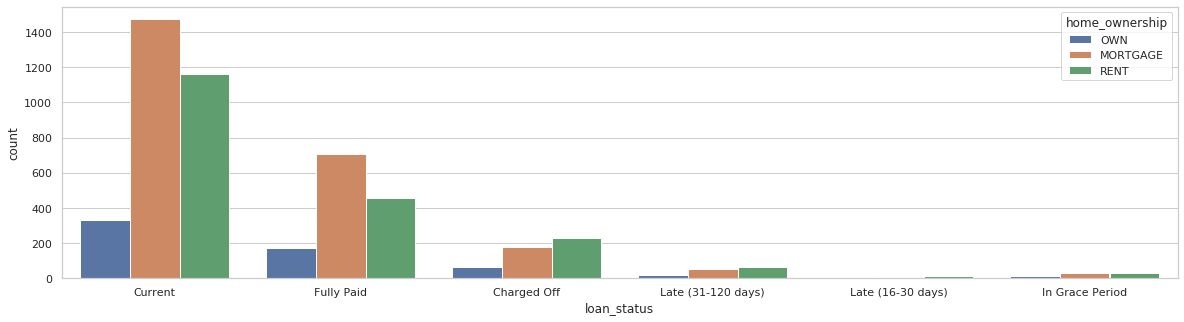

In [17]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")

#tips = sns.load_dataset("tips")

#ax = sns.barplot(x="loan_status", y="loan_amnt_count", data=df)
#ax = sns.barplot(x="loan_status", y="loan_amnt", data=vis_df)
ax = sns.countplot(x="loan_status", hue="home_ownership", data=vis_df)


### Borrowing by State 
Most of the money in terms of absolute borrowing is borrowed by people from California. For average loan amount per state, Alaska ranks on top.

In [18]:
# Create an aggregated dataframe ...
df=vis_df[['addr_state', 'loan_amnt', ]].groupby(['addr_state']).agg(['mean', 'sum'])
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df=df.reset_index()
df


,addr_state,loan_amnt_mean,loan_amnt_sum
0,AK,18736.764706,318525.0
1,AL,16365.254237,965550.0
2,AR,15363.194444,553075.0
3,AZ,14891.818182,1638100.0
4,CA,16176.603499,11097150.0
5,CO,14323.437500,1375050.0
6,CT,16274.285714,1139200.0
7,DC,20660.000000,206600.0
8,DE,16397.500000,327950.0
9,FL,14995.844504,5593450.0


In [ ]:
#Plotly Choropleth Example 

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df['addr_state'], # Spatial coordinates
    z = df['loan_amnt_mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "USD",
))

fig.update_layout(
    title_text = '2016 Lending Club Avg Loans by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()    

### Optional Exercise  : Loan Purpose Wordcloud
Lets try to get a sense of why people are borrowing ...

In [ ]:
loan_df_orig['desc']

In [ ]:
#purpose_count = vis_df[['loan_status','purpose']].groupby('purpose').agg(['mean', 'sum'])

# Create an aggregated dataframe ...
#purpose_count=vis_df[['purpose', 'loan_amnt', ]].groupby(['purpose']).agg(['count'])
#df.columns = ['_'.join(col).strip() for col in df.columns.values]
#df=df.reset_index()
#df
text = " ".join(str(purpose) for purpose in loan_df_orig['title'])

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(background_color="white").generate(text)
# Display the generated image:
plt.figure(figsize=(20,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


As you can see, this could go on forever, but hopefully you get a sense of the power of data visualization

### Modelling Phase

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/modeling.png" width="800" height="500" align="middle"/>

### Train / Test set creation

One of the key points in any machine learning workflow is the **partitioning** of the data set into **train** and **test** sets.  The key idea here is that a model is built using the training data, and evaluated using the test data.  

There are more nuances to how you partition data into train/test sets, but for purposes of this lab we will omit these finer points.

In [19]:
%load_ext autoreload
%autoreload 2
from lc_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Instantiate lendingclub_ml object that will hold our test, and contain methods used for testing.
# Implementation done like this to ease the burden on users for keeping track of train/test sets for different
# models we are going to build.

my_analysis = lendingclub_ml(loan_df)

In [29]:
# Create a train / test split of your data set.  Paramter is test set size percentage 
# Returns data in the form of dataframes

my_analysis.create_train_test(test_size=0.40)

**create_train_test** : Dropping 2 timestamp columns issue_d and earliest_cr_line
**create_train_test** :  2 timestamp columns issue_d and earliest_cr_line unavailable to drop
**create_train_test** : Training set size: (69471, 132)
**create_train_test** : Testing set size: (46314, 132)
**create_train_test** : Train set loan_default:loan_paid ratio : 15624/53847
**create_train_test** : Test  set loan_default:loan_paid ratio : 10299/36015


### Dimension Reduction
For this modeling exercise we will perform a couple of tasks, **dimension reduction** and **classification** as shown in the following diagram.

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-workflow.png" width="800" height="500" align="middle"/>

**Dimension Reduction** is useful in scenarios when you have a large number of columns and you would like to reduce that down to a compressed representation .  In this lab we will try 2 methods of dimension reduction.  It will be your choice to decide which method you want to use for the classification part of the lab ! (you could even decice to bypass this if you want ...)


## Dimension Reduction - PCA

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-pca.png"  width="200" height="125" align="middle"/>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.

A simple way to think about PCA is that it helps compress the data in a lossy representation of the original dataset.

This will also be used to help us visualize the data as you will see below

**build_pca_model** : Explained Variance : [0.05850498 0.05140628 0.03866846 0.02792865 0.02212167 0.0217774
 0.02052316 0.01911016 0.01854286 0.01736437 0.01643951 0.01607636
 0.01587897 0.01573609 0.01527398 0.01461498 0.01435002 0.01406419
 0.01353544 0.01323885]


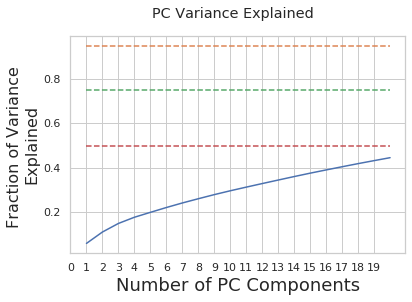

In [30]:
# Dimension Reduction using PCA
my_analysis.build_pca_model(n_components=20)

In the chart above, you can see that we get ok results from PCA.  Using the first 20 principal components, we can account for ~50% of the variance described in the dataset.  **Feel free to change the number of principal components above to see if adding more helps with explained variance.**

### Now update our test dataframe with new columns that are predicted by our PCA.  

Here we will now take the models that we built and pass our test data set through the models.   By doing this, we will have reduced the number features in our data set by a significant amount (~177 colums => ~5-20 columns!)  .  

In this step we will add new columns to our test/train data frames for  our PCA model .  Don't worry about the details of this step, its just required for some followon visualization, and training steps ahead. 



In [31]:
my_analysis.update_train_test_df()

**update_df** : Starting update for train dataframe 
**update_df** : Adding PCA columns first
**update_df** : Creating new columns : {0: 'PC0', 1: 'PC1', 2: 'PC2', 3: 'PC3', 4: 'PC4', 5: 'PC5', 6: 'PC6', 7: 'PC7', 8: 'PC8', 9: 'PC9', 10: 'PC10', 11: 'PC11', 12: 'PC12', 13: 'PC13', 14: 'PC14', 15: 'PC15', 16: 'PC16', 17: 'PC17', 18: 'PC18', 19: 'PC19'}
**update_df** : Updating train Dataframe 
**update_df** : Starting update for test dataframe 
**update_df** : Adding PCA columns first
**update_df** : Creating new columns : {0: 'PC0', 1: 'PC1', 2: 'PC2', 3: 'PC3', 4: 'PC4', 5: 'PC5', 6: 'PC6', 7: 'PC7', 8: 'PC8', 9: 'PC9', 10: 'PC10', 11: 'PC11', 12: 'PC12', 13: 'PC13', 14: 'PC14', 15: 'PC15', 16: 'PC16', 17: 'PC17', 18: 'PC18', 19: 'PC19'}
**update_df** : Updating test Dataframe 


### Cool Visualizations using our dimension reduction columns

Next we will plot a few scatterplot grids based on our pricipal component and autoencoder representations of the data

We will color each data point using this key
```
Green -> Fully paid or current loan
Red   -> Loan in default
```

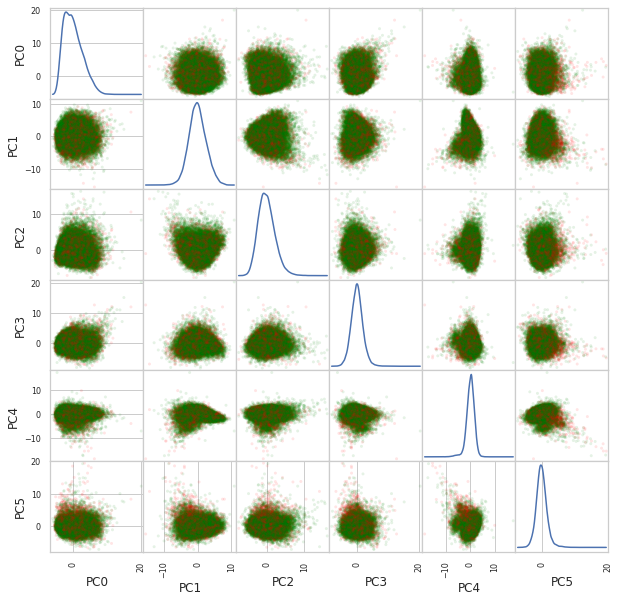

In [32]:
# This will take a minute or so ...
my_analysis.visualize_dimred_results(mode='pca')

If you can discern a pattern between the red / green dots, its likely we can use a classifier to automatically seperate them! We'll see that in a few more sections

### [Optional : Heatmaps ]
Using a heatmap can be another good visualization tool.  You can use this to get a sense of how the data correlates to each other.  In the code below, play with the **sortColumn** input .  In the example below we are sorting by principal component 0, which has the most information encoded in that column.  See if you can find out what PC0 might be composed of.  Try it for PC1

Pro tip, to get the most out of a heatmap, all the data needs to be normalized on a common 0 -> 1 scale so that the coloring of the columns works out ..


In [ ]:
# This will take a minute or so ...
bob_heatmap_lc(my_analysis.test_df,sortColumn='PC0',add_corr=1)

The resolution is quite small, but try to find columns that go from solid red on bottom to black on top. That would be an indication of high correclation to your sort column

# Final Step - Lending Club Default Prediction

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-traintest.png"  width="600" height="375" align="middle"/>

Here we will build a classifier to predict if loan will fail or not.  We will us a 
** Deep Learning Classifier **  .  You will have 3 options for data sources, 
* the raw data
* PCA dimension reduction features
* Autoencoder features

To evaluate our model, we will use a simple contingency table (showing true/false positve/negative).  However, this is a fairly simplistic method.  Better method that data scientists use are F1 score, and PR/ROC curves but thats beyond the scope of this lab.

Step 1 here is to set our baseline result.  In this example, we are dealing with a **skewed** dataset.  This means, on average, most people will not default, and they pay their loan off.  If you built a classifier that just predicted no default, you would be right most of the time.  Lets see the stats from our dataset below....

In [33]:
# Set our baseline
my_analysis.train_df['default'].describe()

count    69471.000000
mean         0.224900
std          0.417519
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

As you can see, **only ~12.8% of the applicants default**.  Any classifier we build must be better than this, or we aren't doing a very good job ;)

In [34]:
# modes
# pca           : principal components only
# ae            : autoencoder components only
# raw           : all the data non reduced
# raw_no_grades : all the data non reduced except the grade info provided by lending club

mode = 'raw' # ae , raw, raw_no_grades

if(mode == 'pca') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' in x]
elif(mode == 'raw') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' not in x]
elif(mode == 'raw_no_grades') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' not in x]
            import re
            x_cols = [x for x in x_cols if not re.match('^[ABCDEFG]',x)]



In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = my_analysis.train_df[x_cols]
y = my_analysis.Y_train

In [36]:
## Simple XGBoost Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X,y)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

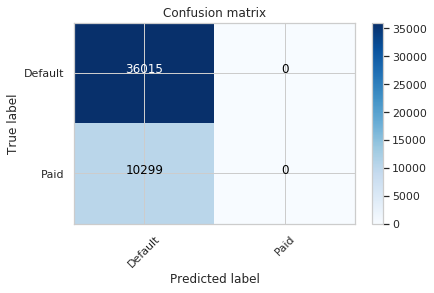

In [37]:
Y_test_predict = np.where(clf.predict(my_analysis.test_df[x_cols]) > 0.5, 1, 0 )

cnf_matrix =confusion_matrix(my_analysis.Y_test, Y_test_predict)
class_names =  ['Default','Paid']
plot_confusion_matrix(cnf_matrix, class_names)

### Credits 
* Bob Chesebrough - IBM CSSC Data Scientist
* Catherine Cao - IBM FSS Data Scientist
* [Hands on Machine Learning - Geron] (https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)
